In [1]:
#--------------- Packages ---------------#
import os
import sys
import emcee
import random
import fitsio
import Corrfunc
import numpy as np
from classy import Class
import cluster_toolkit as ctk
from astropy.table import Table
import matplotlib.pyplot as plt
from getdist import plots, MCSamples
from colossus.halo import concentration
from chainconsumer import ChainConsumer
from colossus.cosmology import cosmology
from scipy.stats import norm#, multivariate_normal
from colossus.halo import profile_composite, concentration, profile_nfw, profile_einasto
plt.style.use("/global/homes/t/titus/Titus/Lensing/GitHub/mass_calibration_of_DM_halos/MNRAS.mplstyle")
# plt.rcParams["font.family"] = "Times New Roman"
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

burnin = 1000
filepath = "/pscratch/sd/t/titus/Cardinal/mcmc_results/"
data_path = r"/global/u2/t/titus/Titus/Lensing/data/"
reader_c_file = filepath+"cardinal_mcmc_testrun_ctk_10per_cov_0.2_0.35_13.0_13.5.h5"

def read_c_file(c_file, burnin):
    labels2 = [r"$\rm \log_{10}\mathit{M_{vir}}$", r"$\rm \mathit{c_{vir}}$"]
    labels22 = [r"\rm \log_{10}\mathit{M_{vir}}", r"\rm \mathit{c_{vir}}"]
    names = ["M", "c"]

    burnin = 1000
    reader_c = emcee.backends.HDFBackend(c_file)
    samples_c = reader_c.get_chain()
    flat_samples_c = reader_c.get_chain(discard=burnin, flat=True)
    
    lnprob = reader_c.get_log_prob(discard=burnin, flat=True)
    # best_fit_params  = flat_samples_c[np.argmax(lnprob)] #best fit parameters
    # params = np.array([best_fit_params[0], best_fit_params[1]])
    
    posterior_means = np.mean(flat_samples_c, axis=0) #posterior mean
    params = np.array([posterior_means[0], posterior_means[1]])
    
    return flat_samples_c, samples_c, labels2, labels22, names, params

flat_samples_c, samples_c, labels2, labels22, names, params = read_c_file(reader_c_file, burnin)

In [2]:
# Set cardindal cosmology
cosmo_params = {'flat': True, 'H0': 70, 'Om0': 0.286, 'Ob0': 0.047, 'sigma8': 0.82, 'ns': 0.96}
cosmology.addCosmology('cardinal', cosmo_params)
cosmo = cosmology.setCosmology('cardinal')
h = cosmo_params['H0']/100

## Cluster toolkit cosmology
#Start by specifying the cosmology
Omega_b = cosmo_params['Ob0']
Omega_m = cosmo_params['Om0']
Omega_cdm = Omega_m - Omega_b
sigma8 = cosmo_params['sigma8']
h = cosmo_params['H0']/100 # McClintock h value
# A_s = 2.1e-9 #np.exp(3.064)/1e10 NB: ln(1e10*As)=3.064
n_s = cosmo_params['ns']
# z = 0.3

#Create a params dictionary
#Need to specify the max wavenumber
k_max = 1000 #UNITS: 1/Mpc

params = {
         'output':'mPk',
         'h':h,
         'sigma8':sigma8,
         'n_s':n_s,
         'Omega_b':Omega_b,
         'Omega_cdm':Omega_cdm,
         'P_k_max_1/Mpc':k_max,
         'z_max_pk':1.0, #Default value is 10
         'non linear':'halofit'
}

#Initialize the cosmology and compute everything
cosmo_ctk = Class()
cosmo_ctk.set(params)
cosmo_ctk.compute()

In [3]:
def log_likelihood(params, rp, z, input_units = "physical"):
    log10_M, c = params
    M = (10**log10_M) #Msun/h

    a = 1/(1+z) # scale factor
    Rproj = np.logspace(-2, 2.4, num=1000, base=10) #Mpc/h Projected 2D radii. 
    R3d = np.logspace(-2, 3, num=1000, base=10) #Mpc/h comoving. 3D radii.
    
    # McClintock radial bins
    Rmin = 0.0323
    Rmax = 30
    nbins = 15
    Redges = np.logspace(np.log10(Rmin), np.log10(Rmax), nbins+1) #Projected radial bin edges
    Redges *= h*(1+z)

    """
    Note:
    Minimum Rproj for Sigma(Rproj) must be >= than min(r) of xi(r).
    Maximum Rproj for Sigma(Rproj) must be <= than max(r) of xi(r).
    Thus, the range of values for Rproj must be 
    equal to (or contained in) that of r
    """
    
    #Specify k and z
    # k = np.logspace(-5, 3, num=4000) #Mpc^-1 comoving
    k = np.logspace(-5, np.log10(k_max), num=4000) #Mpc^-1 comoving
    # Power spectrum
    Pnonlin = np.array([cosmo_ctk.pk(ki, z) for ki in k])#*h**3  #Mpc^3/h^3 comoving
    Plin = np.array([cosmo_ctk.pk_lin(ki, z) for ki in k])#*h**3  #Mpc^3/h^3 comoving
    kh = k/h #h/Mpc comoving
    # k /= h #h/Mpc comoving
    #P(k) are in Mpc^3/h^3 comoving
    #Thus, you will need to convert these to h/Mpc and (Mpc/h)^3 to use in the toolkit.
    Plin *= h**3
    Pnonlin *= h**3

    # NFW profile
    xi_nfw = ctk.xi.xi_nfw_at_r(R3d, M, c, Omega_m)

    # # Matter-matter correlation function (matter auto-correlation)
    xi_mm = ctk.xi.xi_mm_at_r(R3d, kh, Pnonlin)

    # 2-halo correlation function
    bias_term = ctk.bias.bias_at_M(M, kh, Plin, Omega_m) # Here, P must be linear. 
    xi_2halo = ctk.xi.xi_2halo(bias_term, xi_mm)

    # Halo-matter correlation function
    xi_hm = ctk.xi.xi_hm(xi_nfw, xi_2halo)

    # Sigma (computed from xi_hm)
    Sigma = ctk.deltasigma.Sigma_at_R(Rproj, R3d, xi_hm, M, c, Omega_m)
    # Sigma = ctk.deltasigma.Sigma_nfw_at_R(Rproj, M, c, Omega_m)

    # DeltaSigma (excess surface density)
    DS = ctk.deltasigma.DeltaSigma_at_R(Rproj, Rproj, Sigma, M, c, Omega_m)
    ave_DS = ctk.averaging.average_profile_in_bins(Redges, Rproj, DS)
    
    if input_units == "physical":
        # model = ave_DS*(1+z)**2 #convert to hMsun/pc^2 physical
        model_ctk = ave_DS*h*(1+z)**2 #convert to Msun/pc^2 physical
    else:
        model_ctk = ave_DS
    
    #################################################
    ## Colossus profile
    # rp_phys = Rp_mid*1e3 #kp/h physical
    rp_phys = (rp*1e3)*h #kp/h physical
    p_nfw = profile_nfw.NFWProfile(M = M, c = c, z = z, mdef = 'vir') #cardinal overdensity definition is vir
    
    p_einasto = profile_einasto.EinastoProfile(M = M, c = c, z = z, mdef = 'vir') #cardinal overdensity definition is vir

    #-------------Calculating Delta Sigma for nfw and einasto profile
    ## nfw
    ds_nfw = p_nfw.deltaSigma(rp_phys)
    ## einasto
    ds_einasto = p_einasto.deltaSigma(rp_phys)
    
    if input_units == "physical":
        ds_theory_nfw = h*ds_nfw*1e-6  # colossus works in physical units; hence, there is no need to do ds_nfw*a**2*1e-6  
        ds_theory_einasto = h*ds_einasto*1e-6  # colossus works in physical units; hence, there is no need to do ds_einasto*a**2*1e-6 
    else:
        ds_theory_nfw = h*ds_nfw*a**2*1e-6  
        ds_theory_einasto = h*ds_einasto*a**2*1e-6  
    ############################################
    return model_ctk#, ds_theory_nfw, ds_theory_einasto #DS_model#, ave_DS


In [4]:
Rmin_phys_mpc = 0.0323
Rmax_phys_mpc = 30
nbins_phys_mpc = 15
lnrp_bins_phys_mpc = np.linspace(np.log(Rmin_phys_mpc), np.log(Rmax_phys_mpc), nbins_phys_mpc+1)
rp_bins_phys_mpc = np.exp(lnrp_bins_phys_mpc)
rp_phys_mpc = np.sqrt(rp_bins_phys_mpc[:-1]*rp_bins_phys_mpc[1:])
rp = rp_phys_mpc
sel = rp > 0.10
# sel = (rp > 0.10)&(rp < 9)
rp1 = rp[sel]

# mid_scale_sel0 = (rp>=0.3)&(rp<3)
# scale_sel = mid_scale_sel0[sel]
# run_name = "_fullrun_ctk_halorun_mid_scale_0.3_3"
# run_name = "_fullrun_ctk_halorun_small_scale_0.2_3_new_new"


# large_scale_sel0 = (rp>=3)&(rp<30)
# scale_sel = large_scale_sel0[sel]
# run_name = "_fullrun_ctk_halorun_large_scale_3_30"

all_scale_sel0 = (rp>=0.1)&(rp<999)
scale_sel = all_scale_sel0[sel]
# run_name = "_fullrun_ctk_halorun_all_scale_final"
run_name = "_fullrun_ctk_halorun_all_scale_final_final"

z_lower = [0.2, 0.2, 0.2, 0.2, 0.35, 0.35, 0.35, 0.35, 0.5, 0.5, 0.5, 0.5]
z_upper = [0.35, 0.35, 0.35, 0.35, 0.5, 0.5, 0.5, 0.5, 0.7, 0.7, 0.7, 0.7]
lambda_lower = [20, 30, 45, 60, 20, 30, 45, 60, 20, 30, 45, 60]
lambda_upper = [30, 45, 60, 500, 30, 45, 60, 500, 30, 45, 60, 500]
halos_ds =  Table(np.load(data_path+"stacked_DS_halo_run.npy", allow_pickle=True))

bias_ls = []
for i in range(len(halos_ds)):
# for i in range(11):
    # run_name = "_fullrun_ctk_halorun_mid_scale_0.3_3"
    # run_name = "_fullrun_ctk_halorun_large_scale_3_30"
    readerfile = filepath+f"cardinal_mcmc{run_name}_{z_lower[i]}_{z_upper[i]}_{lambda_lower[i]}_{lambda_upper[i]}.h5"
    # print(readerfile)
    # readerfile = filepath+f"cardinal_mcmc_testrun_ctk_halorun_0.2_0.35_20_30.h5"
    z = halos_ds["Redshift"][i]
    log10_M = halos_ds["Mvir"][i]

    c = halos_ds["cvir"][i]
    true_params = np.array([log10_M, c])
    print(f"z bin = [{z_lower[i]}, {z_upper[i]}]")
    print(f"Mass bin = [{lambda_lower[i]}, {lambda_upper[i]}]")
    print(f"True mass = {log10_M}")

    flat_samples_c, samples_c, labels2, labels22, names, params = read_c_file(readerfile, burnin)
    data_ds = log_likelihood(true_params, rp, z, input_units = "physical")
    model_ctk = log_likelihood(params, rp, z, input_units = "physical")
    bias = params[0] - log10_M
    # bias = (10**log10_M)/(10**params[0])
    bias_ls.append(bias)
bias_arr0 = np.array(bias_ls)
# print(bias_arr) 

z bin = [0.2, 0.35]
Mass bin = [20, 30]
True mass = 14.256152153015137
z bin = [0.2, 0.35]
Mass bin = [30, 45]
True mass = 14.481986999511719
z bin = [0.2, 0.35]
Mass bin = [45, 60]
True mass = 14.567497253417969
z bin = [0.2, 0.35]
Mass bin = [60, 500]
True mass = 14.776834487915039
z bin = [0.35, 0.5]
Mass bin = [20, 30]
True mass = 14.0364408493042
z bin = [0.35, 0.5]
Mass bin = [30, 45]
True mass = 14.268896102905273
z bin = [0.35, 0.5]
Mass bin = [45, 60]
True mass = 14.446784973144531
z bin = [0.35, 0.5]
Mass bin = [60, 500]
True mass = 14.660221099853516
z bin = [0.5, 0.7]
Mass bin = [20, 30]
True mass = 13.925470352172852
z bin = [0.5, 0.7]
Mass bin = [30, 45]
True mass = 14.175905227661133
z bin = [0.5, 0.7]
Mass bin = [45, 60]
True mass = 14.392958641052246
z bin = [0.5, 0.7]
Mass bin = [60, 500]
True mass = 14.619837760925293


In [5]:
from chainconsumer import ChainConsumer
ci_68_lower_ls = []
ci_68_upper_ls = []
# Open a file once outside the loop to append the results

for i in range(len(halos_ds)):
    # run_name = "_fullrun_ctk_halorun_mid_scale_0.3_3"
    # run_name = "_fullrun_ctk_halorun_small_scale_0.2_3_new_new"
    run_name = "_fullrun_ctk_halorun_large_scale_3_30"
    # run_name = "_fullrun_ctk_halorun_all_scale_final"
    # run_name = "_fullrun_ctk_halorun_all_scale_final_final"
    
    readerfile = filepath + f"cardinal_mcmc{run_name}_{z_lower[i]}_{z_upper[i]}_{lambda_lower[i]}_{lambda_upper[i]}.h5"
    flat_samples_c, samples_c, labels2, labels22, names, params = read_c_file(readerfile, burnin)

    # Creating a ChainConsumer instance and adding the chain
    c = ChainConsumer()
    c.add_chain(flat_samples_c, parameters=labels2)

    # Configure the ChainConsumer instance for only 68% confidence intervals
    c.configure(sigmas=[1])  # This sets the confidence intervals to 68%

    # Retrieving the summary
    summary = c.analysis.get_summary()

    # Extract and save only for the first parameter
    first_param = labels2[0]  # Assuming labels2 contains the parameter labels
    values = summary[first_param]
    
    if len(values) >= 3 and None not in values[:3]:  # Check if 68% CI values are available and not None
        mean = values[1]
        ci_68 = f"{mean:.4f} [-{(mean - values[0]):.4f}, +{(values[2] - mean):.4f}]"
        lower = np.round(mean - values[0], 4)
        upper = np.round(values[2] - mean, 4)
        ci_68_lower_ls.append(lower)
        ci_68_upper_ls.append(upper)
    else:
            ci_68 = "Data insufficient for 68% CI"

ci_68_lower_ls = np.array(ci_68_lower_ls)
ci_68_upper_ls = np.array(ci_68_upper_ls)

In [6]:
# # Small scale
# np.save("small_scale_bias_arr.npy", bias_arr)
# np.save("small_scale_ci_68_upper.npy", ci_68_upper_ls)
# np.save("small_scale_ci_68_lower_ls.npy", ci_68_upper_ls)

# # Large scale
# np.save("large_scale_bias_arr.npy", bias_arr)
# np.save("large_scale_ci_68_upper.npy", ci_68_upper_ls)
# np.save("large_scale_ci_68_lower_ls.npy", ci_68_upper_ls)

# # All scale
# np.save("all_scale_bias_arr.npy", bias_arr)
# np.save("all_scale_ci_68_upper.npy", ci_68_upper_ls)
# np.save("all_scale_ci_68_lower_ls.npy", ci_68_lower_ls)

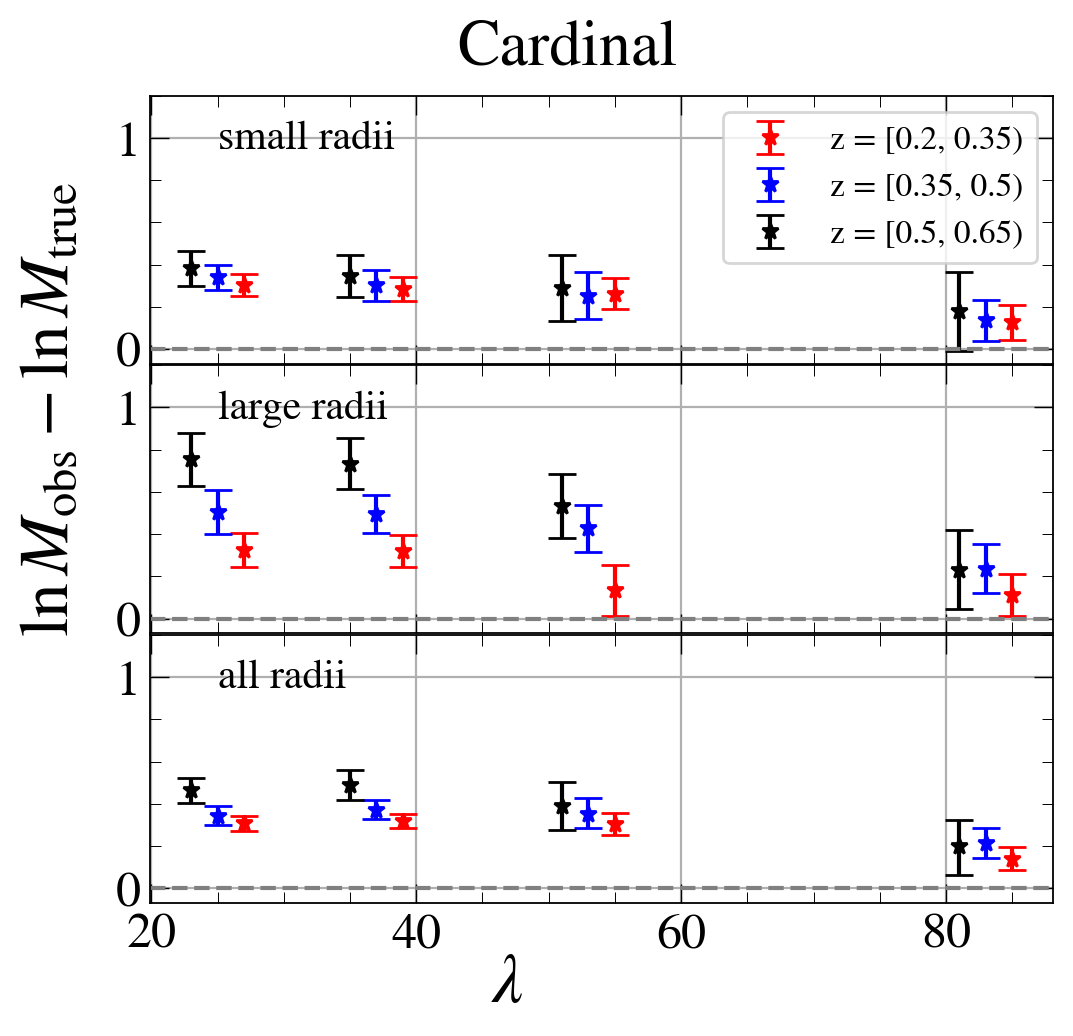

In [4]:
###############################
#################################
B1 = [27, 39, 55, 85]
B2 = [25, 37, 53, 83]
B3 = [23, 35, 51, 81]

cardinal_path = "/global/u2/t/titus/Titus/Lensing/codes/notebooks/cardinal/"
bias_arrays1 = [np.load(cardinal_path+"small_scale_bias_arr.npy"), np.load(cardinal_path+"large_scale_bias_arr.npy"), np.load(cardinal_path+"all_scale_bias_arr.npy")]
ci_68_lower_arrays = [np.load(cardinal_path+"small_scale_ci_68_lower_ls.npy"), np.load(cardinal_path+"large_scale_ci_68_lower_ls.npy"), np.load(cardinal_path+"all_scale_ci_68_lower_ls.npy")]
ci_68_upper_arrays = [np.load(cardinal_path+"small_scale_ci_68_upper.npy"), np.load(cardinal_path+"large_scale_ci_68_upper.npy"), np.load(cardinal_path+"all_scale_ci_68_upper.npy")]
radii_scale = ['small radii', 'large radii', 'all radii']

LN10 = np.log(10.0)
bias_arrays1 = [np.asarray(a, dtype=np.float64) * LN10 for a in bias_arrays1]
ci_68_lower_arrays = [np.asarray(a, dtype=np.float64) * LN10 for a in ci_68_lower_arrays]
ci_68_upper_arrays = [np.asarray(a, dtype=np.float64) * LN10 for a in ci_68_upper_arrays]

# Create a figure and four subplots (2 rows, 2 columns)
drop = 1
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharey=True, sharex = True) 
# plt.rcParams['font.family'] = 'DeJavu Serif'
# plt.rcParams['font.serif'] = ['Times New Roman']

for i in range(3):
    label = "data"

    ########################
    axes[i].set_ylim(-0.07, 1.20)
    axes[i].errorbar(B1, bias_arrays1[i][0:4], yerr=[ci_68_lower_arrays[i][0:4], ci_68_upper_arrays[i][0:4]], fmt='*r', label="z = [0.2, 0.35)", capsize=5)
    axes[i].errorbar(B2, bias_arrays1[i][4:8], yerr=[ci_68_lower_arrays[i][4:8], ci_68_upper_arrays[i][4:8]], fmt='*b', label="z = [0.35, 0.5)", capsize=5)
    axes[i].errorbar(B3, bias_arrays1[i][8:], yerr=[ci_68_lower_arrays[i][8:], ci_68_upper_arrays[i][8:]], fmt='*k', label="z = [0.5, 0.65)", capsize=5)
    axes[i].text(25.0, 0.95, f"{radii_scale[i]}", fontsize = 15)
    axes[i].axhline(y=0, color='grey', linestyle='--')
    if i == 0:
        axes[i].legend(fontsize=12)
        
# Add a super title, super x label, and super y label
fig.suptitle(r'Cardinal', x = 0.55, y = 0.90, va='center', ha='center', fontsize=23)
fig.supxlabel(r'$\rm \mathit{\lambda}$', x = 0.50, y = 0.12, va='center', ha='center', fontsize=25)
fig.supylabel(r'$\rm \ln\mathit{M}_{obs}-\ln\mathit{M}_{true}$', x = 0.12, y = 0.6, va='center', ha='center', fontsize=25)

# Adjust spacing between subplots
plt.tight_layout(h_pad = -0.20, w_pad = 0.0)
plt.show()